In [1]:
from herbert_emotion_classifier.wordnet_dataset import EmotionsInTextDataset
from herbert_emotion_classifier.baseline_dataset import EmotionsInTextBaselineDataset 
from herbert_emotion_classifier.model import HerbertEmotionClassifier
from herbert_emotion_classifier.datamodule import EmotionsInTextDatamodule

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

from os.path import join

import pandas as pd

In [2]:
model = HerbertEmotionClassifier()

In [3]:
train_ds = EmotionsInTextBaselineDataset(join("..", "data", "wust_train.json"))
val_ds = EmotionsInTextBaselineDataset(join("..", "data", "wust_test.json"))

In [4]:
dm = EmotionsInTextDatamodule(128, train_ds, val_ds)

In [5]:
x, y = next(iter(dm.val_dataloader()))

In [6]:
# logger = WandbLogger(name="unet_resnet50",project="pst_segmentation")

seed_everything(42)

trainer = Trainer(max_epochs=100,
                  gpus=1,
                  deterministic=True,
                  accumulate_grad_batches=4,
                  checkpoint_callback=False,
                  callbacks=[EarlyStopping(monitor='val/loss')],
                  logger=False
                  )

trainer.fit(model, dm)

model.eval()
a=1
# model.freeze()


GPU available: True, used: True
I1219 17:47:23.446281 140504249214784 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1219 17:47:23.446937 140504249214784 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1219 17:47:23.447408 140504249214784 accelerator_connector.py:402] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | RobertaModel     | 124 M 
2 | classifier | Sequential       | 99 K  
I1219 17:47:24.802625 140504249214784 lightning.py:1295] 
  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | RobertaModel     | 124 M 
2 | classifier | Sequential       | 99 K  


In [7]:
from herbert_emotion_classifier.predict import predict
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [8]:
predictions, true_labels = predict(model, dm.val_dataloader(), "cuda")

In [9]:
class_names = ['oczekiwanie', 'podziw', 'radosc', 'smutek', 'strach', 'wstret', 'zaskoczenie', 'zlosc', 'neutralne']

<AxesSubplot:>

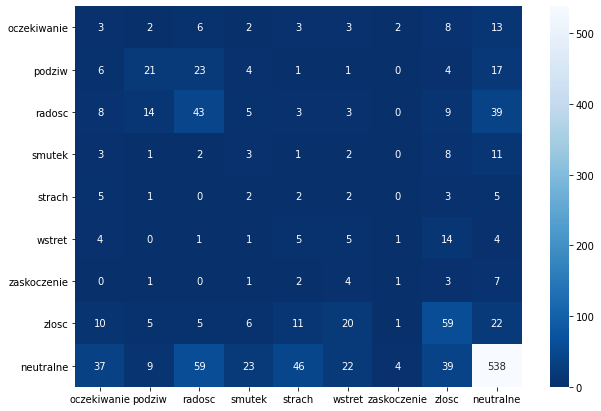

In [10]:
cm = confusion_matrix(true_labels, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (10,7))

sn.heatmap(df_cm, cmap="Blues_r", annot=True, fmt="d")

In [11]:
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

 oczekiwanie       0.04      0.07      0.05        42
      podziw       0.39      0.27      0.32        77
      radosc       0.31      0.35      0.33       124
      smutek       0.06      0.10      0.08        31
      strach       0.03      0.10      0.04        20
      wstret       0.08      0.14      0.10        35
 zaskoczenie       0.11      0.05      0.07        19
       zlosc       0.40      0.42      0.41       139
   neutralne       0.82      0.69      0.75       777

   micro avg       0.53      0.53      0.53      1264
   macro avg       0.25      0.24      0.24      1264
weighted avg       0.61      0.53      0.57      1264

